In [1]:
!pip install colormath

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colormath: filename=colormath-3.0.0-py3-none-any.whl size=39407 sha256=60cd0b6291d18137587a80fa9bcbccf7ff4a8d16ab2c62d3941a24bc0bbc8138
  Stored in directory: /root/.cache/pip/wheels/1a/d7/a7/458a4632ccc8bfe436f5e9db9fef1aa84e5d243a1b4b4c7b59
Successfully built colormath


MOUNT THE DRIVE AND LOAD THE DATASET

In [2]:
import os
import sys
import PIL.Image as Image
import matplotlib.pyplot as plt
import torchvision.transforms as tr

from colormath.color_objects import LCHabColor, sRGBColor
from colormath.color_conversions import convert_color

In [9]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision.transforms as tr
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

import numpy as np

In [4]:
#general variables
n_epochs=100
cycle_lambda = 10.
root_data = "../harmonies_database"

In [5]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd
%ls ../harmonies_database

/content/gdrive/My Drive/Colab Notebooks/harmonie/CycleGAN
analog/  rectangle/


In [73]:
def rgb_to_h_lc(img):
  img_h = np.zeros((img.shape[0],img.shape[1],1))
  img_lc = np.zeros((img.shape[0],img.shape[1],2))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      rgb = sRGBColor(img[i,j,0]/255,img[i,j,1]/255,img[i,j,2]/255)
      lch = convert_color(rgb,LCHabColor)

      img_h[i,j,0]=lch.lch_h
      img_lc[i,j,:]=np.array([lch.lch_l,lch.lch_c])

      if((i*256+j)%10000==0):
        print("did",i*256+j,"pixel")

  return img_h,img_lc

def lch_to_rgb(img_lc,img_h):
  rgb_img = np.zeros((img_h.shape[0],img_h.shape[1],3))
  for i in range(img_lc.shape[0]):
    for j in range(img_lc.shape[1]):
      lch = LCHabColor(img_lc[i,j,0],img_lc[i,j,1],img_h[i,j,0])
      rgb = convert_color(lch,sRGBColor)
      rgb_img[i,j,:] = np.array(rgb.rgb_r,rgb.rgb_g,rgb.rgb_b)
  return rgb_img

def h_to_rgb(img_h):
  rgb_img = np.zeros((img_h.shape[0],img_h.shape[1],3))
  for i in range(img_lc.shape[0]):
    for j in range(img_lc.shape[1]):
      lch = LCHabColor(50,50,img_h[i,j,0])
      rgb = convert_color(lch,sRGBColor)
      rgb_img[i,j,:] = np.array([rgb.rgb_r,rgb.rgb_g,rgb.rgb_b])
  return rgb_img

TEST THE CONVERSION FUNCTIONS

In [66]:
img = np.array(Image.open("for_patches.jpg").resize((256,256)))
img_h,img_lc = rgb_to_h_lc(img)

did 0 pixel
did 10000 pixel
did 20000 pixel
did 30000 pixel
did 40000 pixel
did 50000 pixel
did 60000 pixel


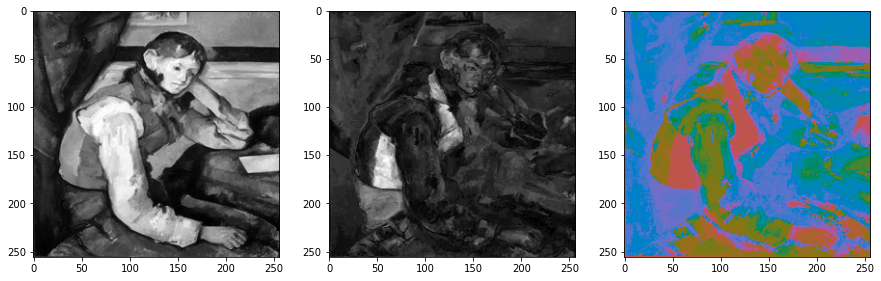

In [75]:
#turn this into a function

l = img_lc[:,:,0].reshape((img_lc.shape[0],img_lc.shape[1]))
c = img_lc[:,:,1].reshape((img_lc.shape[0],img_lc.shape[1]))
h = h_to_rgb(img_h)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(l,cmap="gray")

plt.subplot(1,3,2)
plt.imshow(c,cmap="gray")

plt.subplot(1,3,3)
plt.imshow(h)

In [ ]:
from torch.utils.data import Dataset

#no time so I'm stealing this from https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/GANs/CycleGAN/dataset.py

class HorseZebraDataset(Dataset):
    def __init__(self, root_zebra, root_horse, transform=None):
        self.root_zebra = root_zebra
        self.root_horse = root_horse
        self.transform = transform

        self.zebra_images = os.listdir(root_zebra)
        self.horse_images = os.listdir(root_horse)
        self.length_dataset = max(len(self.zebra_images), len(self.horse_images)) # 1000, 1500
        self.zebra_len = len(self.zebra_images)
        self.horse_len = len(self.horse_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        zebra_img = self.zebra_images[index % self.zebra_len]
        horse_img = self.horse_images[index % self.horse_len]

        zebra_path = os.path.join(self.root_zebra, zebra_img)
        horse_path = os.path.join(self.root_horse, horse_img)

        #!!!!! dans la base de données les teintes sont multipliées par 256./360.

        zebra_array = img_rgb_to_h(np.array(Image.open(zebra_path)))
        horse_array = img_rgb_to_h(np.array(Image.open(horse_path)))

        zebra_img = torch.Tensor(np.moveaxis(zebra_array,-1,0)).to(torch.device("cuda:0"))/360
        horse_img = torch.Tensor(np.moveaxis(horse_array,-1,0)).to(torch.device("cuda:0"))/360


        return zebra_img, horse_img

trainData = HorseZebraDataset(os.path.join(root_data,"analog"),os.path.join(root_data,"rectangle"),transform=tr.RandomHorizontalFlip())
iterData = iter(trainData)

Text(0.5, 0, 'analog')

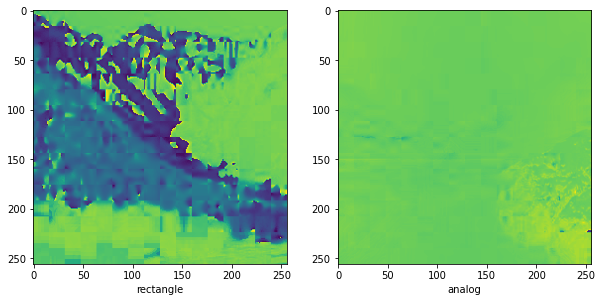

In [ ]:
#display a random couple
summer,winter = next(iterData)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1).reshape((256,256)))
plt.xlabel("rectangle")
plt.subplot(1,2,2)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1).reshape((256,256)))
plt.xlabel("analog")

#MODELS

In [ ]:
from torch.nn.modules.instancenorm import InstanceNorm2d
class Block(nn.Module):
  def __init__(self,in_chan,out_chan,stride,padding):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_chan,out_chan,4,stride,padding,padding_mode="reflect"),
        nn.InstanceNorm2d(out_chan),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self,X):
    return self.conv(X)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,in_chan=3,features=[64,128,256,512]):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(
          in_chan,
          features[0],
          4,stride=2,padding=1,padding_mode="reflect"
        ),
        nn.LeakyReLU(0.2)
    )

    layers=[]
    in_channels=features[0]
    for n_chan in features[1:]:
      layers.append(Block(in_channels,n_chan,2 if n_chan!=features[-1] else 1,1))
      in_channels=n_chan
    self.model = nn.Sequential(*layers)
    self.model.append(
        nn.Sequential(
            nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"),
            nn.Sigmoid()
        )
    )
  
  def forward(self,x):
    x = self.initial(x)
    return self.model(x)

In [ ]:
disc = Discriminator().to(torch.device("cuda:0"))
summary(disc,(3,256,256))

In [ ]:
class convBlock(nn.Module):
  def __init__(self,in_channels,out_channels,use_act=True,down=True,**kwargs):
    super().__init__()
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,**kwargs)
        if down else
        nn.ConvTranspose2d(in_channels,out_channels,**kwargs),
        nn.InstanceNorm2d(out_channels),
        nn.ReLU() if use_act else nn.Identity()
    )

  def forward(self,x):
    return self.block(x)

In [ ]:
class residualBlock(nn.Module):
  def __init__(self,n_channels):
    super().__init__()
    self.block = nn.Sequential(
        convBlock(n_channels,n_channels,kernel_size=3,stride=1,padding=1),
        convBlock(n_channels,n_channels,False,kernel_size=3,stride=1,padding=1)
    )
  def forward(self,x):
    return x + self.block(x)

In [ ]:
class Generator(nn.Module):
  def __init__(self,n_residuals=9,in_channels=3,num_features=64):
    super().__init__()
    self.initial = nn.Sequential(
        nn.Conv2d(in_channels,num_features,7,1,3,padding_mode="reflect"),
        nn.ReLU()
        )
    self.down = nn.ModuleList(
        [
        convBlock(num_features,num_features*2,kernel_size=3,stride=2,padding=1),
        convBlock(num_features*2,num_features*4,kernel_size=3,stride=2,padding=1)
        ]
    )
    self.residual=nn.ModuleList(
        [*[residualBlock(num_features*4) for _ in range(n_residuals)]
        ]
    )
    self.up = nn.ModuleList(
        [
        convBlock(num_features*4,num_features*2,kernel_size=3,stride=2,padding=1,output_padding=1,down=False),
        convBlock(num_features*2,num_features*1,kernel_size=3,stride=2,padding=1,output_padding=1,down=False)
        ]
    )
    self.up.append(nn.Sequential(
        nn.Conv2d(num_features,3,7,1,3,padding_mode="reflect"),
        nn.Tanh()
        )
    )

  def forward(self,x):
    x = self.initial(x)
    for d in self.down:
      x = d(x)
    for r in self.residual:
      x = r(x)
    for u in self.up:
      x = u(x)
    return x

In [ ]:
gen = Generator(n_residuals=4,num_features=64).to(torch.device("cuda:0"))
#summary(gen,(3,256,256))
print(gen(winter))

In [ ]:
def make_the_models():
  disc_S = Discriminator().to(torch.device("cuda:0"))
  disc_W = Discriminator().to(torch.device("cuda:0"))
  gen_S = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  gen_W = Generator(n_residuals=3,num_features=64).to(torch.device("cuda:0"))
  
  opt_d = torch.optim.Adam(list(disc_S.parameters())+list(disc_W.parameters()),lr=0.00004,betas=(0.5,0.999))
  opt_g = torch.optim.Adam(list(gen_S.parameters())+list(gen_W.parameters()),lr=0.00004,betas=(0.5,0.999))

  l1 = nn.L1Loss()
  mse = nn.MSELoss()

  return disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse

In [ ]:
import tqdm

def train(dataset, disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse):

  for i in range(n_epochs):
    i=0
    for summer,winter in tqdm.tqdm(dataset):

      #train the discriminators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss for summer discriminator
        #learn to correctly detect fake summer and real summer (learns both to detect realism AND summer)
        #basically estimating the distribution of summer images through this adversarial loss.
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer.detach())
        pred_real_summer = disc_S(summer)
        loss_disc_S_fake = mse(pred_fake_summer,torch.ones_like(pred_fake_summer))#1 means fake
        loss_disc_S_real = mse(pred_real_summer,torch.zeros_like(pred_real_summer))

        #adversarial loss for winter discriminator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter.detach())
        pred_real_winter = disc_W(winter)
        loss_disc_W_fake = mse(pred_fake_winter,torch.ones_like(pred_fake_winter))#1 means fake
        loss_disc_W_real = mse(pred_real_winter,torch.zeros_like(pred_real_winter))

        #final D loss
        D_loss = (loss_disc_S_fake + loss_disc_S_real + loss_disc_W_fake + loss_disc_W_real)/2


      opt_d.zero_grad()
      D_loss.backward()
      opt_d.step()
      
      #train the generators on their own
      with torch.cuda.amp.autocast():
        #adversarial loss on summer generator
        fake_summer = gen_S(winter)
        pred_fake_summer = disc_S(fake_summer)
        loss_gen_S_adv = mse(pred_fake_summer,torch.zeros_like(pred_fake_summer))
        #adversarial loss on winter generator
        fake_winter = gen_W(summer)
        pred_fake_winter = disc_W(fake_winter)
        loss_gen_W_adv = mse(pred_fake_winter,torch.zeros_like(pred_fake_winter))

        #cycle consistency loss for summer->winter->summer (updates both generators)
        reco_summer = gen_S(fake_winter)
        loss_gen_S_cyc = l1(reco_summer,summer)

        #cycle consistency loss for winter->summer->winter (updates both generators)
        reco_winter = gen_S(fake_summer)
        loss_gen_W_cyc = l1(reco_winter,winter)

        #final generators loss
        G_loss = (loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda + loss_gen_S_adv + loss_gen_W_adv)

      if(i==15):
        print("Gloss adv : ",float(loss_gen_S_cyc*cycle_lambda + loss_gen_W_cyc*cycle_lambda),"Gloss adv : ",float(loss_gen_S_adv + loss_gen_W_adv),"D loss : ",float(D_loss))
        i=0
      i+=1
      #update the weights
      opt_g.zero_grad()
      G_loss.backward()
      opt_g.step()

In [ ]:
#disc_S, disc_W, gen_S, gen_W, opt_d, opt_g, l1, mse = make_the_models()


train(trainData,disc_S, disc_W, gen_S, gen_W, opt_d, opt_g,l1, mse)

In [ ]:
gen_W.to(torch.device("cuda:0"))
#testing results
summer,winter = next(iterData)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(np.moveaxis(np.array(winter.cpu()),0,-1))
plt.title("rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,2)
plt.imshow(np.moveaxis(np.array(gen_S(winter).cpu().detach()),0,-1))
plt.title("generated analog")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,3)
plt.imshow(np.moveaxis(np.array(summer.cpu()),0,-1))
plt.title("analog")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)
plt.subplot(1,4,4)
plt.imshow(np.moveaxis(np.array(gen_W(summer).cpu().detach()),0,-1))
plt.title("generated rectangle")
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

#LOAD AN IMAGE AND CONVERT IT TO RECTANGULAR BY PATCHES

In [ ]:
resize_x = 3
resize_y = 4
width = 256*resize_x
height = 256*resize_y
img=Image.open("for_patches.jpg").resize((256*resize_x,256*resize_y))

plt.figure(figsize=(20,20))
plt.imshow(np.array(img))
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)

In [ ]:
#prepare data
data=[]
for i in range(resize_y):
  for j in range(resize_x):
    patch = np.array(img)[i*256:(i+1)*(256),j*256:(j+1)*(256)]
    patch = np.moveaxis(patch,-1,0)
    data.append(torch.Tensor(patch).cpu())
    data[-1]=data[-1].to(torch.device("cuda:0"))
    
    print("image from ",i*256,",",j*256," to ",(i+1)*(256),",",(j+1)*(256)," shape : ",data[-1].shape,"and type : ",type(data[-1]))

In [ ]:
#pass the patches through the network
patches = []

for patch in data:
    patches.append(np.moveaxis(np.array(gen_S(patch).cpu().detach()),0,-1))

In [ ]:
#stick the patches together into a new image
#reconstruct lines and stick them together
lines=[]
for i in range(resize_y):
  line=patches[i*resize_x]
  for j in range(1,resize_x):
    print(line.shape, "concatenated to : ",patches[i*resize_x+j].shape)
    line= np.concatenate([line,patches[i*resize_x+j]],axis=1)
  print("result : ",line.shape)
  lines.append(line)
img = lines[0]
for i in range(1,resize_y):
  print(img.shape, "concatenated to : ",lines[i].shape)
  img = np.concatenate([img,lines[i]],axis=0)
  print("result : ",img.shape)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(img)
plt.gca().xaxis.set_visible(False)
plt.gca().yaxis.set_visible(False)